In [1]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866


In [2]:
py"""
from fenics import *
from ufl import nabla_div
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Variables
mu = 3e10
rho = 2700
width = 10e3
lambda_ = mu
g = 9.81
# Calculate strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

# Calculate stress
def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Boundary conditions
def clamped_boundary(x, on_boundary):
    return on_boundary

# Create mesh and define function space
mesh = RectangleMesh(Point((-1.5 * width, -3 * width)), Point((1.5 * width, width)), 200, 200)
"""

In [3]:
py"""
V = VectorFunctionSpace(mesh, 'P', 1)
bc = DirichletBC(V, Constant((0, 0)), clamped_boundary)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, -rho*g))
T = Constant((0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Evaluate the solution at a an arbitrary new point
u_eval = u(0, -width)
print(u_eval)
"""

Solving linear variational problem.


In [6]:
py"""
ux = dot(u,Constant((1.0, 0.0)))
uy = dot(u,Constant((0.0, 1.0)))
umag = sqrt(ux ** 2 + uy ** 2)
"""

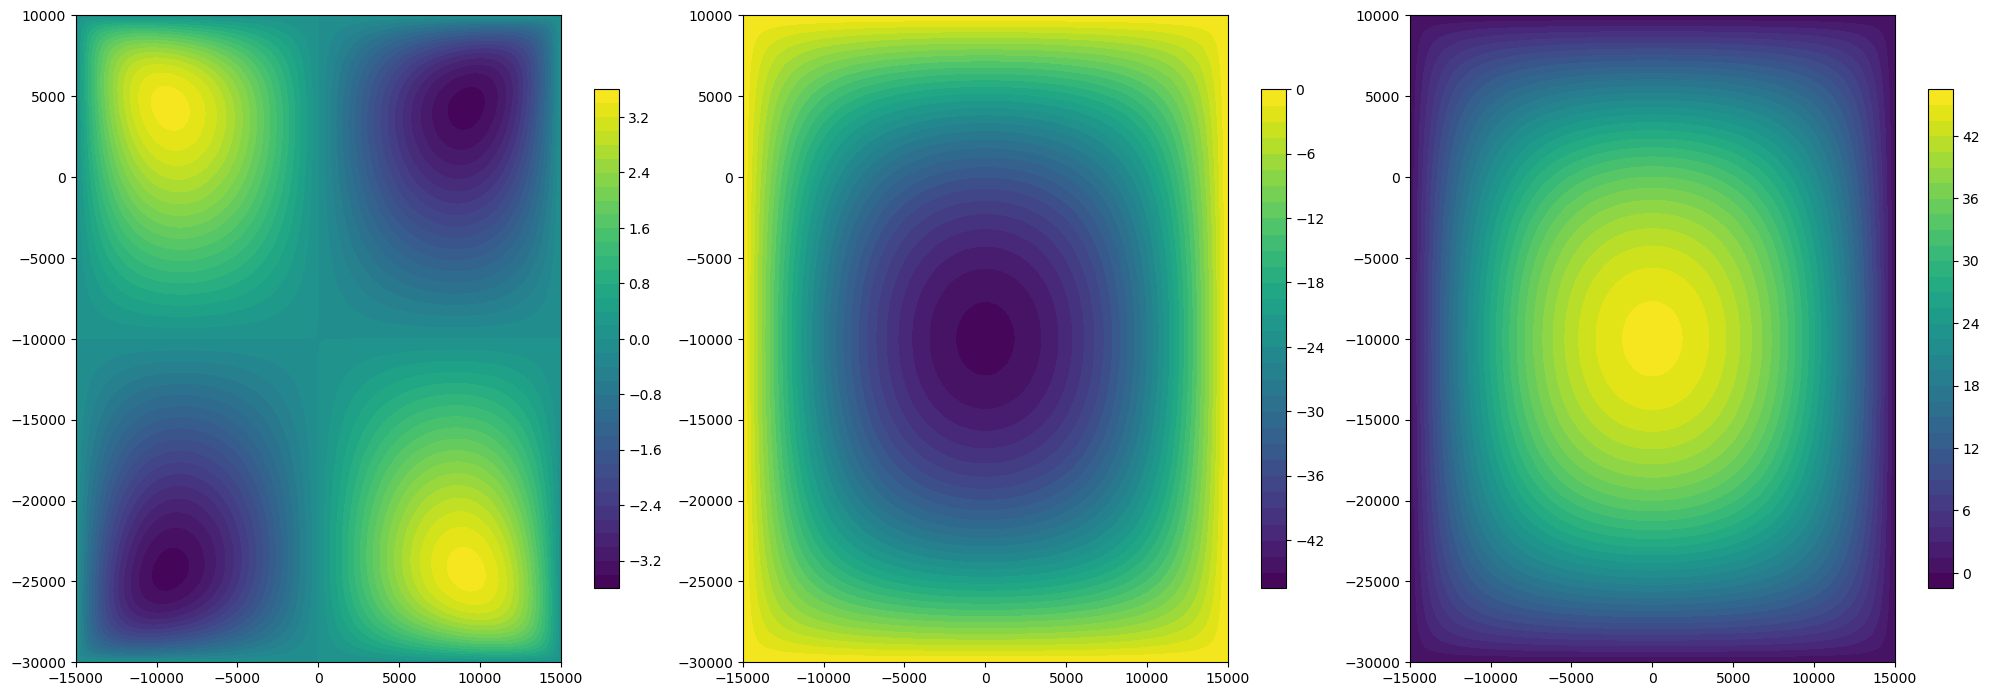

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [7]:
py"""
plt.figure(figsize=(20, 15))

plt.subplot(1,3,1)
c = plot(ux, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)

plt.subplot(1,3,2)
c = plot(uy, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)

plt.subplot(1,3,3)
c = plot(umag, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)
plt.tight_layout()
"""

In [8]:
mu = py"mu"
lambda = py"lambda_"
nu = lambda / (2 * (lambda + mu))
rho = py"rho"
g = py"g"
nels = 50
L = py"width"

10000.0

In [9]:
# Boundary mesh
els = Elements(Int(1e5))
addelsez!(els, discretizedline(-L, -2*L, L, -2*L, nels)..., "B") # Bottom
addelsez!(els, discretizedline(L, -2*L, L, 0, nels)... , "R") # Right hand side
addelsez!(els, discretizedline(L, 0, -L, 0, nels)..., "T") # Top
addelsez!(els, discretizedline(-L, 0, -L, -2*L, nels)..., "L") # Left hand side

In [10]:
all_idx = 1:1:els.endidx
T_pU_qall, _ = PUTC(slip2dispstress, els, all_idx, all_idx, mu, nu)
T = T_pU_qall

400×400 Array{Float64,2}:
  0.5          0.0          0.0        …   0.21865      -0.127574   
  0.0          0.5         -0.0582832     -0.042191      0.133767   
  0.0         -0.0582832    0.5            0.142554     -0.0424014  
  0.0582832    0.0          0.0           -0.022893      0.0446128  
  0.0         -0.0271001    0.0            0.0971468    -0.0185719  
  0.0271001    0.0          0.0582832  …  -0.010698      0.0239721  
  0.0         -0.0178504    0.0            0.0723201    -0.0100893  
  0.0178504    0.0          0.0271001     -0.00592627    0.0162655  
  0.0         -0.0133326    0.0            0.0572712    -0.0062717  
  0.0133326    0.0          0.0178504     -0.0037145     0.0123333  
  0.0         -0.0106459    0.0        …   0.0472988    -0.00425801 
  0.0106459    0.0          0.0133326     -0.0025326     0.00995039 
  0.0         -0.00886249   0.0            0.0402411    -0.00307377 
  ⋮                                    ⋱                            
  0.0099

In [43]:
function fem_eval(n, x, y)
    fem_eval = zeros(2*n)
    for i in 1:n
        fem_eval[(2*i - 1):(2*i)] = py"u"(x[i], y[i])
    end
    return fem_eval
end
u_bc_fem = fem_eval(length(all_idx), els.xcenter, els.ycenter)

400-element Array{Float64,1}:
  -2.7583537250848598
 -22.00928240429895  
  -2.804264124582987 
 -23.12760132331672  
  -2.830097417808186 
 -24.18010491010075  
  -2.8358339323377693
 -25.16648895014989  
  -2.8233082496067583
 -26.092331249111588 
  -2.793410975897538 
 -26.95994540153148  
  -2.746312167857561 
   ⋮                 
  -2.1537352871675344
 -23.70941213628373  
  -2.261565634082464 
 -23.341223076346743 
  -2.3682133773120633
 -22.95248168901165  
  -2.4733864774324714
 -22.54280762181872  
  -2.576743720130165 
 -22.11178320540195  
  -2.677887708228478 
 -21.658949657641877 

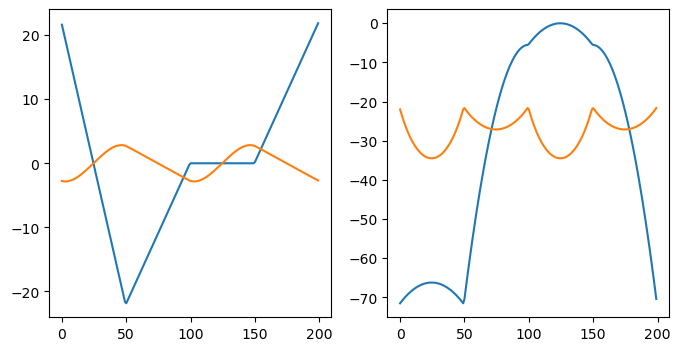

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5eca1229d0>

In [12]:
# Modified displacment BCs for bottom
Upart, _ = gravityparticularfunctions(els.xcenter[all_idx], els.ycenter[all_idx], g, rho, lambda, mu)
bcs_gravity = zeros(2 * els.endidx)
bcs_gravity[1:2:end] = -Upart[:, 1]
bcs_gravity[2:2:end] = -Upart[:, 2]
figure(figsize=(8,4))
subplot(1,2,1)
plot(bcs_gravity[1:2:end])
plot(u_bc_fem[1:2:end])
subplot(1,2,2)
plot(bcs_gravity[2:2:end])
plot(u_bc_fem[2:2:end])

In [32]:
bcs, include_gravity = -u_bc_fem, false
#bcs, include_gravity = bcs_gravity, true

([2.7583537250848598, 22.00928240429895, 2.804264124582987, 23.12760132331672, 2.830097417808186, 24.18010491010075, 2.8358339323377693, 25.16648895014989, 2.8233082496067583, 26.092331249111588  …  2.261565634082464, 23.341223076346743, 2.3682133773120633, 22.95248168901165, 2.4733864774324714, 22.54280762181872, 2.576743720130165, 22.11178320540195, 2.677887708228478, 21.658949657641877], false)

In [25]:
# Modified traction BCs for top
Ueff = T \ bcs

400-element Array{Float64,1}:
 -1.717934663767267  
 19.010273323896026  
 -1.9935317395215613 
 21.170153694525006  
 -2.1256170636856306 
 23.1725637237171    
 -2.1598773582950472 
 25.03826056411146   
 -2.1311859978332537 
 26.782339092445365  
 -2.061164411699318  
 28.41033316209538   
 -1.966178506385896  
  ⋮                  
  3.0953040430121908 
 18.206805736491635  
  2.8282397484521096 
 17.763957610893062  
  2.4639961082171418 
 17.343083229481923  
  1.979028012130567  
 16.96385205174051   
  1.331362268169328  
 16.65578373339107   
  0.40531854631153497
 16.41308350140116   

In [51]:
function interior_eval(x, y)
    out = constdispstress(slip2dispstress, x, y, els, all_idx, Ueff[1:2:end], Ueff[2:2:end], mu, nu)[1]
    if include_gravity
        out += gravityparticularfunctions(x, y, g, rho, lambda, mu)[1]
    else
        fem_xy = fem_eval(length(x), x, y)
        out[:, 1] += fem_xy[1:2:end]
        out[:, 2] += fem_xy[2:2:end]
    end
    return out
end
bem_val = interior_eval([0], [-L])'
#bem_val[2], fem_val[2], bem_val[2] - fem_val[2]

2×1 Adjoint{Float64,Array{Float64,2}}:
  -0.0005064917033108262
 -13.427124997995747    

In [52]:
# Forward solution on grid
npts = 50
offset = 100
x, y = obsgrid(-L+offset, -2*L+offset, L-offset, -offset, npts)
Utotal = interior_eval(x,y)
Umag = sqrt.(Utotal[:, 1].^2 + Utotal[:, 2].^2)

2500-element Array{Float64,1}:
 0.24594537817456372 
 0.06540958749771456 
 0.018453203617177307
 0.021617084912684967
 0.05043120611391952 
 0.07531794734807928 
 0.09787927229264601 
 0.1177884453689584  
 0.13517949809215915 
 0.15157818656140937 
 0.16619702945869483 
 0.17868257130903697 
 0.19096621065541647 
 ⋮                   
 0.1786825713090442  
 0.1661970294586689  
 0.15157818656139624 
 0.1351794980922246  
 0.11778844536893379 
 0.09787927229260807 
 0.07531794734807341 
 0.050431206113870294
 0.02161708491268108 
 0.018453203617191834
 0.06540958749771739 
 0.24594537817456907 

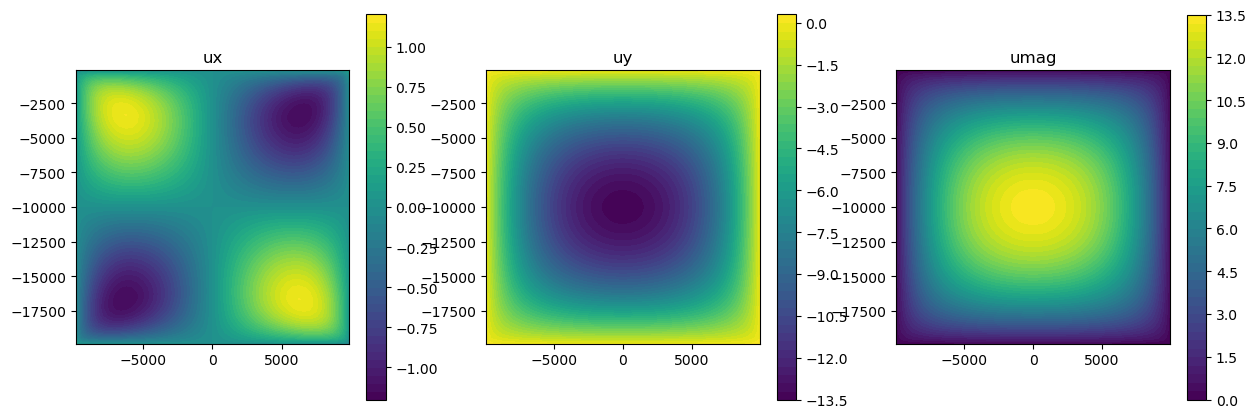

PyObject Text(0.5, 1.0, 'umag')

In [53]:
figure(figsize=(15, 5))
subplot(1, 3, 1)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 1], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("ux")
subplot(1, 3, 2)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 2], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("uy")
subplot(1, 3, 3)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Umag, npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("umag")